In [31]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
df = pd.read_csv("/Circadian Trust.csv", encoding="utf-8")

In [33]:
# Data overview

In [34]:
df.head()

,Site,Gender,Postcode,Plan,Age,Signing/Join Date
0,YT,M,BS37 4JQ,12 Month Total Lifestyle Older Adult Membership,72,2015/7/1
1,YT,F,BS37 4HS,12 Month Total Lifestyle Adult Membership,54,2015/7/1
2,YT,F,BS32 0EU,12 Month Total Lifestyle BodyTone Concession,79,2015/7/2
3,YT,F,BS36 2EN,12 Month Total Lifestyle BodyTone Concesssion,75,2015/7/2
4,YT,F,BS37 9TR,12 Month Total Lifestyle Corporate Membership,67,2015/7/2


In [35]:
df.shape

(6533, 6)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6533 entries, 0 to 6532
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Site               6533 non-null   object
 1   Gender             6533 non-null   object
 2   Postcode           6533 non-null   object
 3   Plan               6533 non-null   object
 4   Age                6533 non-null   int64 
 5   Signing/Join Date  6533 non-null   object
dtypes: int64(1), object(5)
memory usage: 306.4+ KB


In [37]:
print(df.describe())
print(df.describe(include='object'))

               Age
count  6533.000000
mean     47.202510
std      15.009362
min      18.000000
25%      36.000000
50%      47.000000
75%      58.000000
max      93.000000
        Site Gender  Postcode                                  Plan  \
count   6533   6533      6533                                  6533   
unique     2      2      2619                                   191   
top       BS      F  BS32 8GB  12 Month Lifestyle Adult Membership    
freq    3318   3906        29                                  1102   

       Signing/Join Date  
count               6533  
unique              2095  
top            2024/12/2  
freq                  50  


In [38]:
df.isnull().sum()

,0
Site,0
Gender,0
Postcode,0
Plan,0
Age,0
Signing/Join Date,0


In [39]:
# Data Cleaning

In [40]:
# Due to data confusion, membership information needs to be extracted from Plan column

In [41]:
# Preprocessing Plan column (lowercase, remove spaces)
df['Plan'] = df['Plan'].str.lower().str.strip().replace(r'\s+', ' ', regex=True)

# Replace bodytone with wellbeing studio due to name change
df['Plan'] = df['Plan'].str.replace('bodytone', 'wellbeing studio')

In [42]:
# Extract membership information from the Plan column
# Define the function that extracts the Membership Period
def get_membership_period(plan_str):
    if "12" in plan_str:
        return "12 month"
    elif "3" in plan_str:
        return "3 month"
    elif "month to month" in plan_str or "to month" in plan_str or "flex" in plan_str:
        return "month to month"
    elif "annual" in plan_str:
        return "annual"
    else:
        return "1 month"

# Define the function that extracts the Membership Type
def get_membership_type(plan_str):
    # If "refer" is included, further determine other keywords
    if "refer" in plan_str:
        if "wellbeing studio" in plan_str and "biocircuit" in plan_str:
            return "Referral Membership including Wellbeing and BioCircuit"
        elif "wellbeing" in plan_str:
            return "Referral Membership including Wellbeing"
        elif "healthy weight" in plan_str:
            return "Referral Healthy Weight Membership"
        else:
            return "Referral Membership"

    # If "wellbeing" is included
    if "wellbeing" in plan_str:
        if "concession" in plan_str or "conc" in plan_str:
            return "Wellbeing Studio Concession Membership"
        else:
            return "Wellbeing Studio Membership"

    # Extract member information based on subsequent conditions
    if "older" in plan_str:
        return "Older Person Concession Membership"
    elif "student" in plan_str:
        return "Student Concession Membership"
    elif "junior" in plan_str:
        return "Junior Concession Membership"
    elif "corp" in plan_str:
        return "Corporate Concession Membership"
    elif "staff" in plan_str or "family" in plan_str:
        return "Staff & Family Membership"
    elif "swimstars" in plan_str:
        return "Swimstars DD Child 25mins"
    elif "couple" in plan_str:
        return "Adult Couple Membership"
    elif "concession" in plan_str or "conc" in plan_str or "discount" in plan_str:
        return "Adult Concession Membership"
    else:
        return "Adult Membership"

# Extract membership information from the Plan column
df["Membership Period"] = df["Plan"].apply(get_membership_period)
df["Membership Type"] = df["Plan"].apply(get_membership_type)

df.head()

,Site,Gender,Postcode,Plan,Age,Signing/Join Date,Membership Period,Membership Type
0,YT,M,BS37 4JQ,12 month total lifestyle older adult membership,72,2015/7/1,12 month,Older Person Concession Membership
1,YT,F,BS37 4HS,12 month total lifestyle adult membership,54,2015/7/1,12 month,Adult Membership
2,YT,F,BS32 0EU,12 month total lifestyle wellbeing studio conc...,79,2015/7/2,12 month,Wellbeing Studio Concession Membership
3,YT,F,BS36 2EN,12 month total lifestyle wellbeing studio conc...,75,2015/7/2,12 month,Wellbeing Studio Concession Membership
4,YT,F,BS37 9TR,12 month total lifestyle corporate membership,67,2015/7/2,12 month,Corporate Concession Membership


In [43]:
# Convert Signing/Join Date column to standard date type
df["Signing/Join Date"] = pd.to_datetime(df["Signing/Join Date"], format="%Y/%m/%d", errors="coerce")

invalid_dates = df["Signing/Join Date"].isnull().sum()
if invalid_dates > 0:
    print(f"There are {invalid_dates} rows with dates that cannot be parsed and have been converted to NaT.")

# Check to include future dates
today = pd.Timestamp.now().normalize()
future_mask = df["Signing/Join Date"] > today
future_dates = df[future_mask]
if not future_dates.empty:
    print("\n[Discover records of future dates]：")
    print(future_dates[["Plan", "Signing/Join Date"]].head(10))

In [44]:
# Standardize Postcode format and validate its correctness
def normalize_uk_postcode(postcode_str: str) -> str:
    if not isinstance(postcode_str, str):
        return None
    pc = re.sub(r"\s+", "", postcode_str.upper())
    match = re.match(r"^([A-Z]{1,2}\d[A-Z0-9]?)(\d[A-Z]{2})$", pc)
    return f"{match.group(1)} {match.group(2)}" if match else None

# Clean and remove invalid postcode rows
df["Postcode"] = df["Postcode"].apply(normalize_uk_postcode)
df.dropna(subset=["Postcode"], inplace=True)

# Extract postcode prefix
df["Postcode_prefix"] = df["Postcode"].str.split().str[0].str[:4]

In [45]:
# Exploratory data analysis

<Figure size 800x600 with 0 Axes>

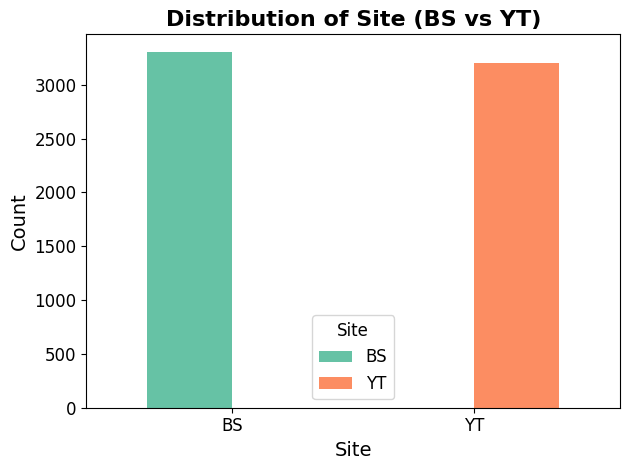

<Figure size 800x600 with 0 Axes>

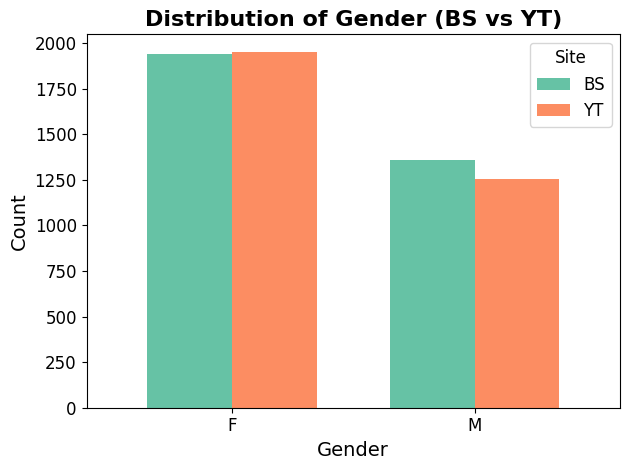

<Figure size 800x600 with 0 Axes>

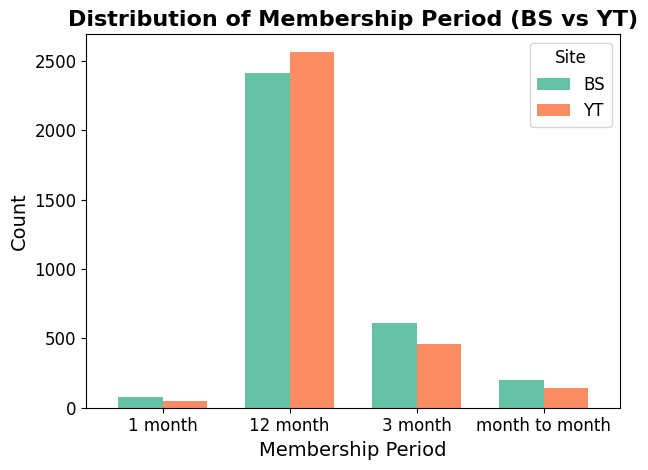

In [46]:
categorical_cols = ["Site", "Gender", "Membership Period"]

for col in categorical_cols:
    plt.figure(figsize=(8, 6))
    grouped_data = df.pivot_table(index=col, columns='Site', aggfunc='size', fill_value=0)

    grouped_data.plot(kind='bar', width=0.7, color=["#66c2a5", "#fc8d62"])

    plt.title(f"Distribution of {col} (BS vs YT)", fontsize=16, fontweight='bold')
    plt.xlabel(col, fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title="Site", fontsize=12, title_fontsize=12)
    plt.tight_layout()
    plt.show()

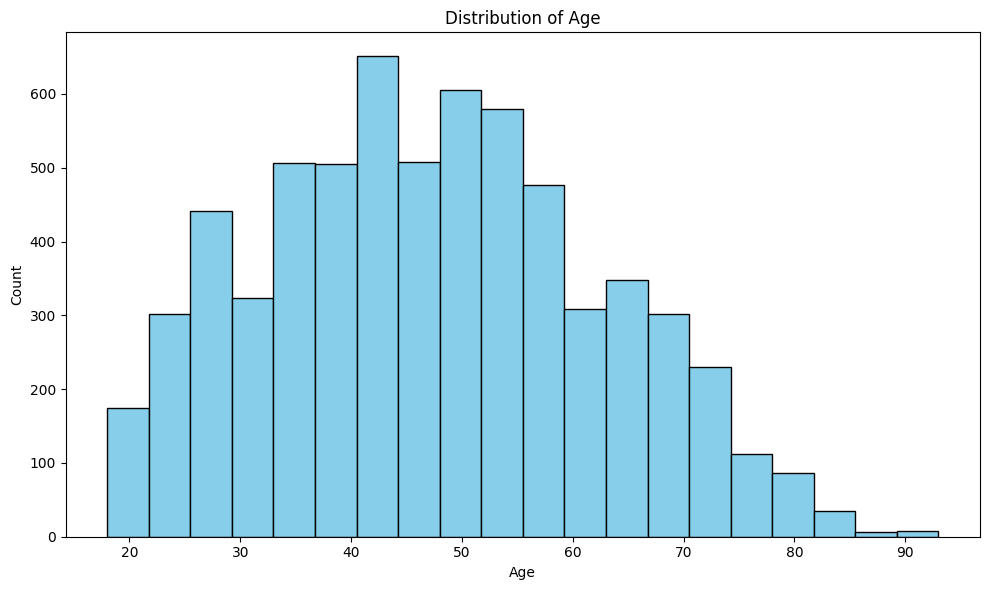

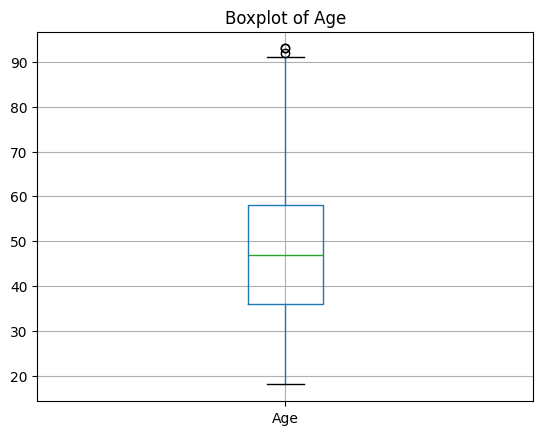

In [47]:
# Age distribution
plt.figure(figsize=(10, 6))
plt.hist(df["Age"], bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Age")
plt.grid(False)
plt.tight_layout()
plt.show()

plt.figure()
df.boxplot(column="Age")
plt.title("Boxplot of Age")
plt.show()

In [48]:
# Distribution of different Membership Type on age
grouped_age = df.groupby("Membership Type")["Age"].agg(["count", "mean", "min", "max"])
print("\nDistribution of different Membership Type on age：")
print(grouped_age.sort_values("mean", ascending=False))


Distribution of different Membership Type on age：
                                                    count       mean  min  max
Membership Type                                                               
Older Person Concession Membership                    413  72.036320   53   90
Wellbeing Studio Concession Membership                222  68.360360   25   93
Referral Membership including Wellbeing                 1  67.000000   67   67
Referral Membership including Wellbeing and Bio...     32  56.625000   36   91
Wellbeing Studio Membership                           100  56.520000   22   79
Referral Membership                                   347  54.282421   23   87
Adult Couple Membership                                42  49.833333   27   70
Referral Healthy Weight Membership                     46  48.217391   22   78
Adult Concession Membership                           638  47.929467   18   92
Junior Concession Membership                          764  46.824607   18   71
S

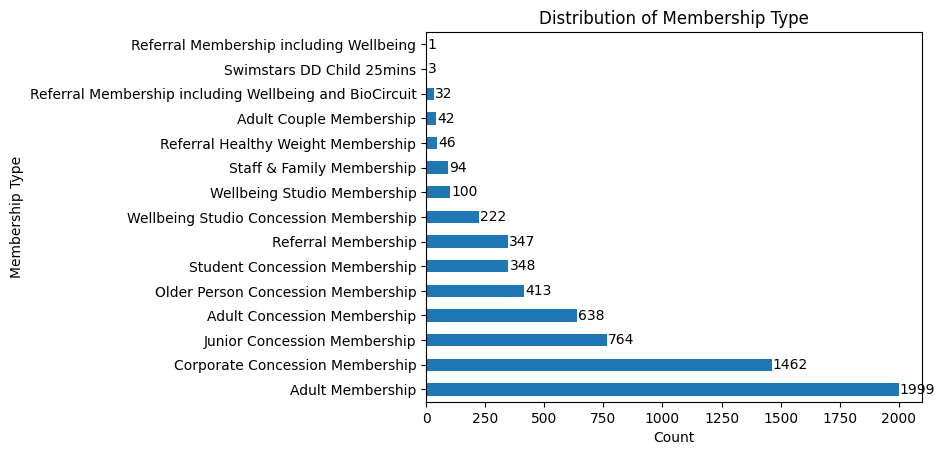

In [49]:
# Distribution of Membership Type
plt.figure()
value_counts = df["Membership Type"].value_counts()
ax = value_counts.plot(kind="barh")
plt.xlabel("Count")
plt.ylabel("Membership Type")
plt.title("Distribution of Membership Type")

for idx, value in enumerate(value_counts):
    ax.text(value + 5, idx, str(value), va='center', fontsize=10)

plt.show()

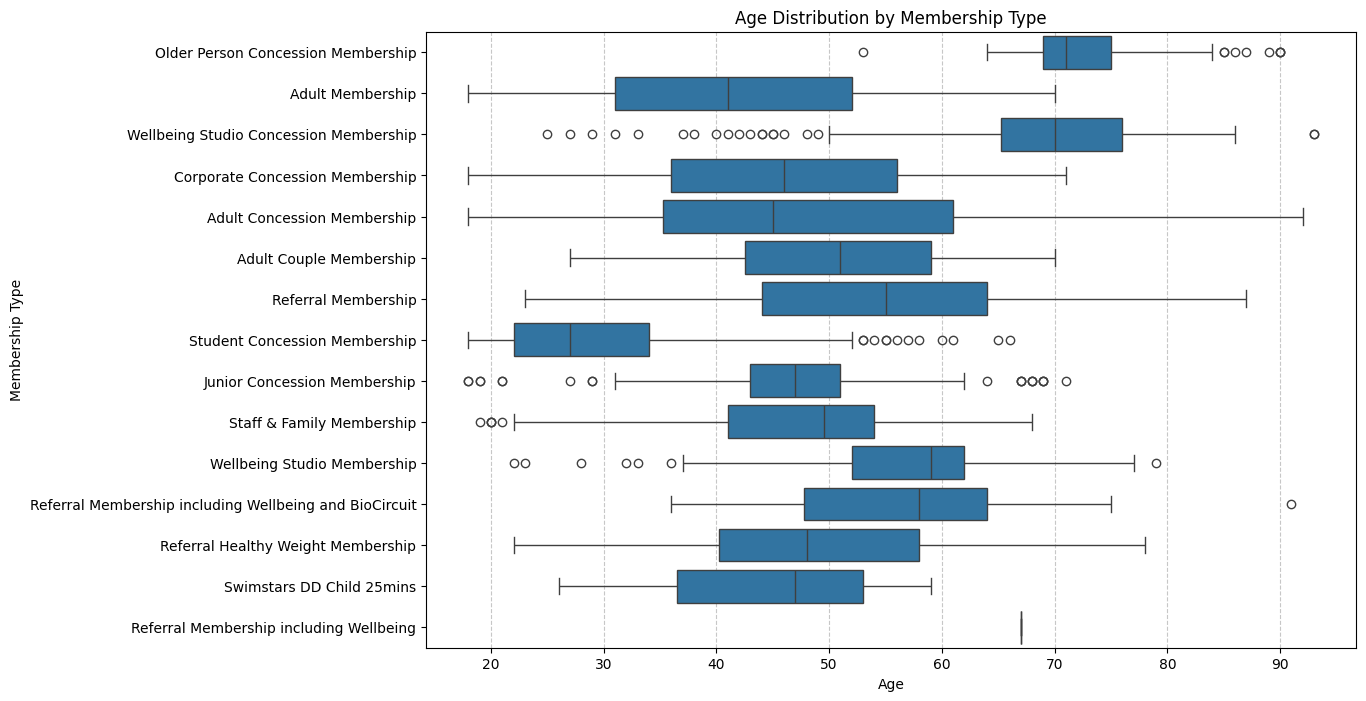

In [50]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="Age", y="Membership Type", data=df, orient='h')
plt.title("Age Distribution by Membership Type")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


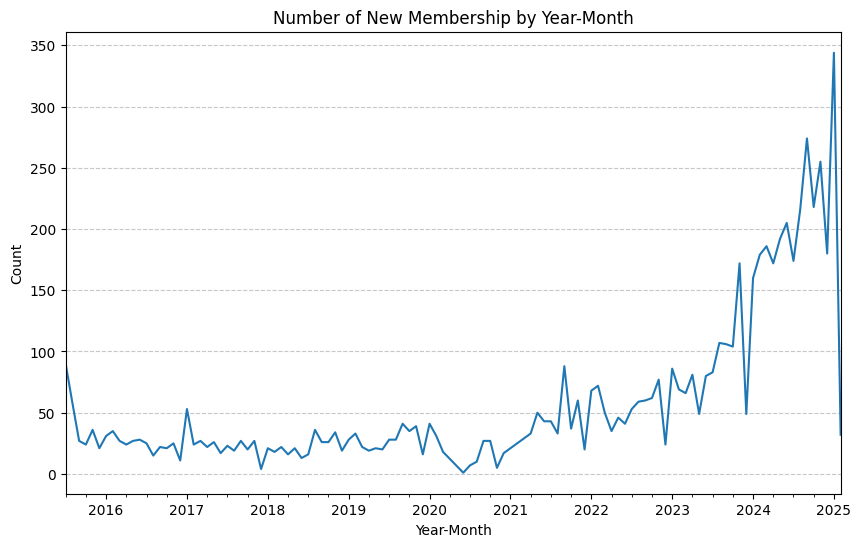

In [51]:
# Trends in new membership
df_trend = df[['Signing/Join Date']].copy()
df_trend["YearMonth"] = df_trend["Signing/Join Date"].dt.to_period("M")

# Counting the number of registrations per month
trend = df_trend.groupby("YearMonth").size()

plt.figure(figsize=(10, 6))
trend.plot()
plt.title("Number of New Membership by Year-Month")
plt.xlabel("Year-Month")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Figure size 1000x600 with 0 Axes>

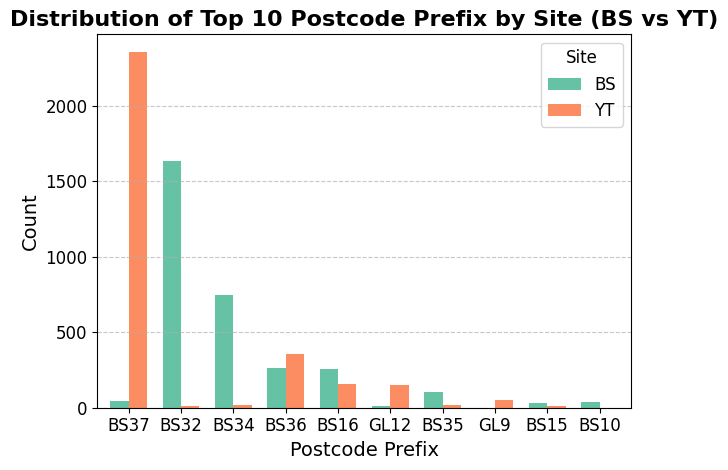

In [52]:
# Counts by Postcode prefix and Site grouping
grouped_data = df.pivot_table(index="Postcode_prefix", columns="Site", aggfunc='size', fill_value=0)

# Top 10 postcode prefixes to visualise
top_prefixes = grouped_data.sum(axis=1).nlargest(10).index
grouped_data = grouped_data.loc[top_prefixes]

plt.figure(figsize=(10, 6))
grouped_data.plot(kind='bar', width=0.7, color=["#66c2a5", "#fc8d62"])

plt.title("Distribution of Top 10 Postcode Prefix by Site (BS vs YT)", fontsize=16, fontweight='bold')
plt.xlabel("Postcode Prefix", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Site", fontsize=12, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [53]:
df.to_csv("Circadian_Trust_cleaned.csv", index=False, encoding="utf-8")